In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Financial/Weekly Fuel Prices dataset.csv')
df.head()

,Date,Petrol (USD),Diesel (USD),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,09-06-2003,74.59,76.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16-06-2003,74.47,76.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23-06-2003,74.42,76.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30-06-2003,74.35,76.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07-07-2003,74.28,76.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.tail()

,Date,Petrol (USD),Diesel (USD),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
876,23-03-2020,119.64,123.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,30-03-2020,112.45,118.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,06-04-2020,110.23,116.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,13-04-2020,109.27,116.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,20-04-2020,108.63,115.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.drop(['Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],axis=1,inplace=True)
time = pd.date_range(start='9/2/2003',periods=881,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [6]:
df.shape

(881, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2003-09-07 to 2020-07-19
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Petrol (USD)  881 non-null    float64
 1   Diesel (USD)  881 non-null    float64
dtypes: float64(2)
memory usage: 20.6 KB


In [8]:
df = df[['Petrol (USD)']]
df.columns=['USD']

In [9]:
df.head()

,USD
time_stamp,
2003-09-07,74.59
2003-09-14,74.47
2003-09-21,74.42
2003-09-28,74.35
2003-10-05,74.28


In [10]:
df.tail()

,USD
time_stamp,
2020-06-21,119.64
2020-06-28,112.45
2020-07-05,110.23
2020-07-12,109.27
2020-07-19,108.63


In [11]:
plt.rcParams['figure.figsize'] = [15,8]

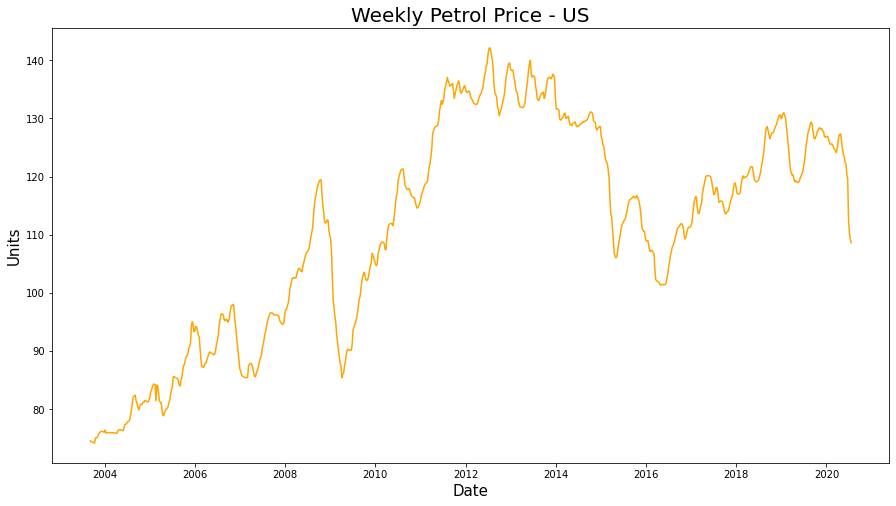

In [12]:
plt.plot(df,color='orange')
plt.title('Weekly Petrol Price - US',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [13]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [14]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['USD'] = df['USD'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [17]:
#Split data set into testing dataset and train dataset
train_size = 750
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 3
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [18]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(747, 3)
(747,)
(128, 3)
(128,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 5.4 MB/s 


In [21]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [22]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 128,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [25]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=34,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 42s]
val_mape: 25.18390464782715

Best val_mape So Far: 0.7776345014572144
Total elapsed time: 00h 04m 20s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 56
dropout: False
learning_rate: 0.0012191474629253307
Dropout_rate: 0.4
units_1: 112
units_2: 96
units_3: 80
units_4: 96
units_5: 16
Score: 0.7776345014572144
Trial summary
Hyperparameters:
num_layers: 5
units_0: 48
dropout: False
learning_rate: 0.00010131378803004744
Dropout_rate: 0.2
units_1: 112
units_2: 88
units_3: 120
units_4: 32
units_5: 48
Score: 0.7828317284584045
Trial summary
Hyperparameters:
num_layers: 5
units_0: 72
dropout: False
learning_rate: 0.0025720070536510388
Dropout_rate: 0.30000000000000004
units_1: 24
units_2: 24
units_3: 48
units_4: 96
Score: 0.7956869006156921
Trial summary
Hyperparameters:
num_layers: 2
units_0: 88
dropout: True
learning_rate: 0.0017047802902184959
Dropout_rate: 0.0
units_1: 104
units_2: 112
units_3: 40
units_4: 16
Score: 0.7979557514190674
Trial summary
Hyperparameters:
num_layer

In [27]:
from warnings import filterwarnings
filterwarnings('ignore')

In [29]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                224       
                                                                 
 dense_1 (Dense)             (None, 112)               6384      
                                                                 
 dense_2 (Dense)             (None, 1)                 113       
                                                                 
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
model = Sequential()
model.add(Dense(56,activation='relu',input_dim = 3))
model.add(Dense(112,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.0012191474629253307)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 34, epochs = 300)

Epoch 1/300
22/22 [==============================] - 1s 22ms/step - loss: 42.0299 - mape: 42.0299 - val_loss: 4.9562 - val_mape: 4.9562
Epoch 2/300
22/22 [==============================] - 0s 6ms/step - loss: 10.2452 - mape: 10.2452 - val_loss: 3.4006 - val_mape: 3.4006
Epoch 3/300
22/22 [==============================] - 0s 6ms/step - loss: 4.0307 - mape: 4.0307 - val_loss: 2.5057 - val_mape: 2.5057
Epoch 4/300
22/22 [==============================] - 0s 6ms/step - loss: 3.5846 - mape: 3.5846 - val_loss: 2.4525 - val_mape: 2.4525
Epoch 5/300
22/22 [==============================] - 0s 7ms/step - loss: 3.5231 - mape: 3.5231 - val_loss: 2.4143 - val_mape: 2.4143
Epoch 6/300
22/22 [==============================] - 0s 7ms/step - loss: 3.4662 - mape: 3.4662 - val_loss: 2.6188 - val_mape: 2.6188
Epoch 7/300
22/22 [==============================] - 0s 13ms/step - loss: 3.5097 - mape: 3.5097 - val_loss: 2.3523 - val_mape: 2.3523
Epoch 8/300
22/22 [==============================] - 0s 15ms/st

In [34]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [35]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.26 
Test MAPE : 0.80 


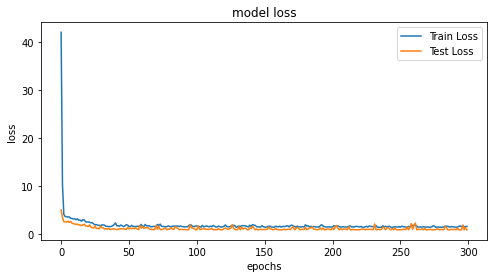

In [36]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [37]:
import seaborn as sns

In [42]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(747,875)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

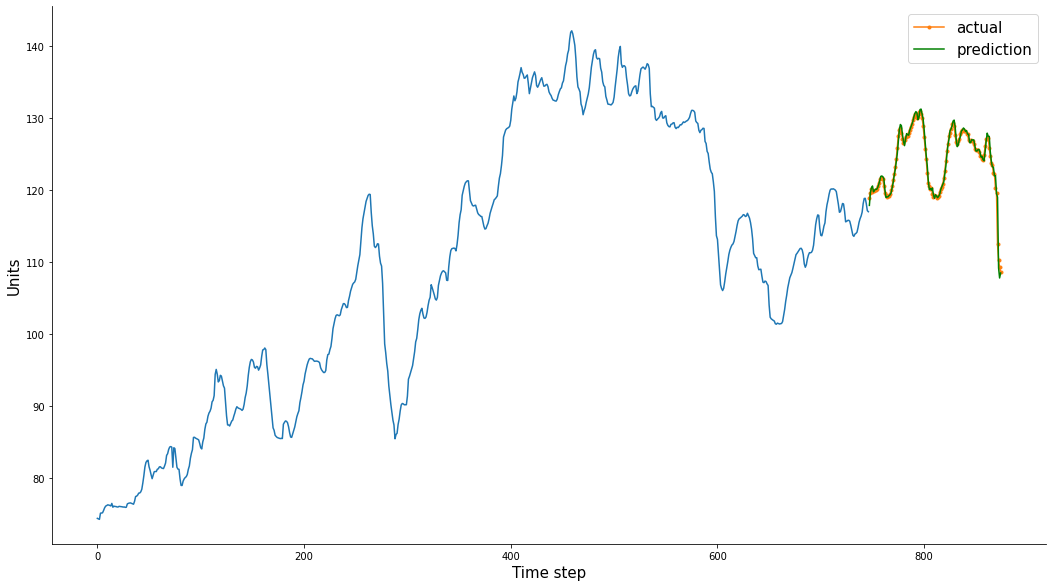

In [43]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)